In [1]:
from dask import diagnostics, widgets
import pandas as pd
from pandas_plink import read_plink
from pandas_plink import get_data_folder
import numpy as np
import os
from os.path import join
import gzip
from io import StringIO
import glob
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

## cis-eQTL for one chromosome

In [2]:
cis_window = 500000
chrom_num = 22

In [ ]:
from pandas_plink import read_plink
import pandas as pd
import numpy as np
import glob

# Base path to the files
file_path = "./LDREF"




'\nbim_combined = []\nfam_combined = []\nbed_combined = []\n\nfor i in range(1, 23):  \n\n    file_base = f"{file_path}/1000G.EUR.{i}"  \n\n    # Read the BIM, FAM, BED files\n    bim, fam, bed = read_plink(file_base)\n    \n    # Append to combined lists\n    bim_combined.append(bim)\n    fam_combined.append(fam)\n    bed_combined.append(bed)\n\n\n'

In [4]:
file_base = f"{file_path}/1000G.EUR.{chrom_num}"  
bim, fam, bed = read_plink(file_base)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 24.64it/s]


In [5]:
gene_exp_df = pd.read_csv('GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz', sep='\t', compression='gzip', header=0)

# Find intersection with gene expression data
gene_exp_samples = gene_exp_df.columns[4:]
matched_samples = set(gene_exp_samples).intersection(fam['iid'])

# Filter gene expression data
filtered_gene_exp = gene_exp_df[['TargetID', 'Gene_Symbol', 'Chr', 'Coord'] + list(matched_samples)]
filtered_gene_exp.loc[:,'Gene_Symbol'] = filtered_gene_exp['Gene_Symbol'].apply(lambda x: x.split('.')[0])
gene_annot = pd.read_csv('gene_annot.txt.gz', sep='\t', compression='gzip', header=0)

combined_filtered_gene_exp = pd.merge(gene_annot, filtered_gene_exp, left_on='SYM', right_on='Gene_Symbol').drop(columns=['TargetID', 'Gene_Symbol', 'Chr'])

In [6]:
gene_exp_chrom = combined_filtered_gene_exp[combined_filtered_gene_exp['CHR'] == chrom_num]

In [7]:
sample_indices = fam[fam['iid'].isin(gene_exp_chrom.columns)]['i'].unique().tolist()

In [8]:
len(sample_indices)

344

In [9]:
bim_chrom = bim[bim['chrom'] == str(chrom_num)] 
bim_chrom.head()

,chrom,snp,cm,pos,a0,a1,i
0,22,rs9617528,0.059576,16061016,C,T,0
1,22,rs4911642,2.127458,16504399,C,T,1
2,22,rs7287144,2.252105,16886873,G,A,2
3,22,rs5748662,2.255191,16892858,A,G,3
4,22,rs5994034,2.255836,16894090,T,C,4


In [10]:
fam_chrom = fam[fam['iid'].isin(gene_exp_chrom.columns)].drop_duplicates()
fam_chrom.head()

,fid,iid,father,mother,gender,trait,i
0,HG00096,HG00096,0,0,0,-9,0
1,HG00097,HG00097,0,0,0,-9,1
2,HG00099,HG00099,0,0,0,-9,2
3,HG00101,HG00101,0,0,0,-9,3
4,HG00102,HG00102,0,0,0,-9,4


In [11]:
gene_exp_chrom

,ID,CHR,START,STOP,SYM,TYPE,Coord,HG00320,HG00109,NA11992,...,HG00232,NA12827,HG00383,NA20774,NA20805,HG00321,HG00284,HG00111,NA12751,HG00252
14076,TPTEP1,22,16601886,16698742,ENSG00000100181,lincRNA,17082777,0.185925,0.203435,0.054817,...,0.027105,0.032731,0.154169,0.178876,0.021584,0.138682,0.109612,0.152036,0.189095,0.093371
14077,CECR7,22,17036569,17060825,ENSG00000237438,lincRNA,17517460,1.123570,0.738311,1.532103,...,0.640684,3.996098,0.438416,0.501395,1.878676,0.470452,0.932302,1.216698,-0.138827,1.235000
14078,IL17RA,22,17084953,17115693,ENSG00000177663,protein_coding,17565844,2.580380,3.773908,2.990411,...,2.532821,3.130056,6.516216,6.954348,2.500827,4.069094,2.773805,3.125675,2.483425,3.326086
14079,CECR6,22,17116298,17121367,ENSG00000183307,protein_coding,17602257,0.010100,0.073524,0.068237,...,0.053998,0.027648,0.045082,0.075619,0.041435,0.015151,0.048417,0.046828,0.077449,0.017031
14080,CECR5,22,17137510,17165287,ENSG00000069998,protein_coding,17646177,27.267517,27.230939,38.081339,...,31.605359,25.771682,27.386406,22.612313,32.924733,31.770295,27.900993,30.982620,18.655526,24.509548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14450,CHKB-AS1,22,50583025,50583877,ENSG00000205559,antisense,51021455,0.339837,0.493989,0.617282,...,0.296301,0.386448,0.399380,0.259015,0.424392,0.950139,0.705295,0.217012,0.789061,0.619564
14451,ARSA,22,50622753,50628179,ENSG00000100299,protein_coding,51066607,5.100634,4.850561,4.489545,...,4.030331,6.845832,5.100789,5.266580,2.160187,7.427782,3.887837,4.493735,6.784537,5.521356
14452,SHANK3,22,50674414,50733298,ENSG00000251322,protein_coding,51113070,0.016057,0.010864,0.014591,...,-0.003729,0.011049,0.010625,0.017023,0.014645,-0.003839,0.014828,0.006472,0.002815,0.001015
14453,RPL23AP82,22,50756947,50801309,ENSG00000184319,transcribed_unprocessed_pseudogene,51195376,12.595851,13.827377,15.841559,...,13.525351,28.951106,12.462425,18.389374,15.800450,16.175383,16.228767,10.098311,11.893010,20.328535


In [12]:
from scipy import stats

# filtered_genotypes_df = pd.DataFrame(filtered_genotypes.compute() , index=sample_indices, columns=bim['snp'])

results = []

for i in range(len(gene_exp_chrom)):
    gene = gene_exp_chrom.iloc[i]
    
    idx, start, stop = gene['ID'], gene['START'] - cis_window, gene['STOP'] + cis_window
    expression = gene.iloc[7:].values.astype(float) # (num_samples, )

    filtered_snps = bim_chrom[(bim_chrom['pos'] >= start) & (bim_chrom['pos'] <= stop)]
    
    snp_indices = filtered_snps['snp'].index.to_list()
    filtered_genotypes = bed[snp_indices, :][:, sample_indices] # (num_snp, num_samples)
    
    snp_genotype_mean = np.mean(filtered_genotypes, axis=1, keepdims=True)  # (num_snp, 1)
    expression_mean = np.mean(expression)  # scalar

    centered_genotypes = filtered_genotypes - snp_genotype_mean
    centered_expression = expression - expression_mean

    numerator = np.dot(centered_genotypes, centered_expression)  # (num_snp,)
    denominator = np.sum(centered_genotypes ** 2, axis=1)  # (num_snp,)

    
    slope = numerator / denominator  # (num_snp,)
    intercept = expression_mean - slope * snp_genotype_mean[:, 0]  # (num_snp,)
    
    fitted_values = intercept[:, None] + slope[:, None] * filtered_genotypes # (num_snps, num_samples)
    ss_total = np.sum((expression - expression_mean) ** 2) # scalar
    ss_residual = np.sum((expression[None, :]  - fitted_values) ** 2, axis=1) # (num_snps, )
    r_squared = 1 - (ss_residual / ss_total) # (num_snps, )
    
    dof = len(expression) - 2  
    std_err = np.sqrt((ss_residual / dof) / denominator) # (num_snps, )
    t_values = slope / std_err # (num_snps, )
    p_values = 2 * stats.t.sf(np.abs(t_values), dof) # (num_snps, )
    
    batch_df = pd.DataFrame({
        'chrom': chrom_num,              
        'gene_id': idx,                    
        'snp': filtered_snps['snp'].values,
        'pos': filtered_snps['pos'].values,
        'ref': filtered_snps['a0'].values,  
        'alt': filtered_snps['a1'].values, 
        'beta': slope,  
        'se': std_err,                             
        'r_squared': r_squared,           
        'p_value': p_values,                        
    })

    results.append(batch_df)


c:\Users\linyo\OneDrive\Desktop\UCSD\CS_DS\DSC 180\myenv\Lib\site-packages\dask\core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\linyo\OneDrive\Desktop\UCSD\CS_DS\DSC 180\myenv\Lib\site-packages\dask\core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\linyo\OneDrive\Desktop\UCSD\CS_DS\DSC 180\myenv\Lib\site-packages\dask\core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\linyo\OneDrive\Desktop\UCSD\CS_DS\DSC 180\myenv\Lib\site-packages\dask\core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\linyo\OneDrive\Desktop\UCSD\CS_DS\DSC 180\myenv\Lib\site-packages\dask\core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in ar

In [13]:
results_df = pd.concat(results, ignore_index=True)
results_df = results_df.dropna(subset=['p_value'])
print(results_df.sort_values('p_value').head())

       chrom gene_id         snp       pos ref alt      beta        se  \
32428     22    GNAZ   rs6003561  23558472   T   C -1.099425  0.123069   
43119     22    UPB1   rs9624395  24460593   C   A -1.929328  0.353915   
43163     22    UPB1  rs11090310  24569468   T   C -1.929328  0.353915   
43139     22    UPB1   rs9620358  24518086   G   A -1.929328  0.353915   
43112     22    UPB1  rs17004823  24447303   A   G -1.929328  0.353915   

       r_squared       p_value  
32428   0.189200  2.601136e-17  
43119   0.079947  9.588345e-08  
43163   0.079947  9.588345e-08  
43139   0.079947  9.588345e-08  
43112   0.079947  9.588345e-08  


In [14]:
results_df.head()

,chrom,gene_id,snp,pos,ref,alt,beta,se,r_squared,p_value
0,22,TPTEP1,rs4911642,16504399,C,T,-0.004224,0.006564,0.001209,0.520345
1,22,TPTEP1,rs7287144,16886873,G,A,0.001396,0.005489,0.000189,0.799451
2,22,TPTEP1,rs5748662,16892858,A,G,0.003162,0.005299,0.001040,0.551101
3,22,TPTEP1,rs5994034,16894090,T,C,0.003893,0.007754,0.000737,0.615945
4,22,TPTEP1,rs4010554,16894264,A,C,0.000676,0.005365,0.000046,0.899784


In [15]:
sorted_results = results_df.sort_values('pos')
sorted_results.to_csv('cis-eQTL_results.txt', sep='\t', index=False)

print("Results saved to 'cis-eQTL_results.txt'")

Results saved to 'cis-eQTL_results.txt'


## Pruning and Thresholding (P + T)

In [16]:
from scipy.spatial.distance import pdist, squareform
import subprocess

In [17]:
sorted_results.columns, bim_chrom.columns

(Index(['chrom', 'gene_id', 'snp', 'pos', 'ref', 'alt', 'beta', 'se',
        'r_squared', 'p_value'],
       dtype='object'),
 Index(['chrom', 'snp', 'cm', 'pos', 'a0', 'a1', 'i'], dtype='object'))

In [ ]:
bim_chrom = bim_chrom.rename(columns={"a0": "ref", "a1": "alt"})
bim_chrom['chrom'] = bim_chrom['chrom'].astype(int)

clump_folder = "./clumps" 
valid_snp_folder = "./valid-snp" 

data_folders = ["./prs_intermediate/clumps", "./prs_intermediate/valid-snp", "./prs_intermediate/indivs", "./prs_intermediate/train", "./results/prs_model_building/valid", "./results/prs_model_building/test", "./prs_intermediate/snp-pval"]

for folder in data_folders:
    os.makedirs(folder, exist_ok=True)

In [ ]:
def clump(p_val, summary_stats = "cis-eqtl_results.txt", clump_kb = 250, clump_r2 = 0.1):
    data = pd.merge(bim_chrom, sorted_results, on=["chrom", "snp", "pos", "ref", "alt"])
    data = data[data['p_value'] < 1]
    
    plink_command = (
        f".\plink --bfile ./LDREF/1000G.EUR.{chrom_num} --clump-p1 {p_val} --clump-r2 {clump_r2} "
        f"--clump-kb {clump_kb} --clump {summary_stats} "
        f"--clump-snp-field snp --clump-field p_value --allow-no-sex --out {f'./prs_intermediate/clumps/EUR__{p_val}'}"
    )

    
    try:
        result = subprocess.run(plink_command, shell=True, check=True, capture_output=True, text=True)
        print("PLINK output:", result.stdout)  
    except subprocess.CalledProcessError as e:
        print("Error occurred:", e.stderr)  


In [20]:
clump(0.05)

PLINK output: PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./clumps/EUR__0.05.log.
Options in effect:
  --allow-no-sex
  --bfile ./LDREF/1000G.EUR.22
  --clump cis-eqtl_results.txt
  --clump-field p_value
  --clump-kb 250
  --clump-p1 0.05
  --clump-r2 0.1
  --clump-snp-field snp
  --out ./clumps/EUR__0.05

16075 MB RAM detected; reserving 8037 MB for main workspace.
17489 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./clumps/EUR__0.05.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
To

In [ ]:
def valid_snp_idx(p_val):
    command = f"""
        Get-Content ./prs_intermediate/clumps/EUR__{p_val}.clumped |
        Select-Object -Skip 1 |
        ForEach-Object {{ ($_ -split '\\s+')[3] }} |
        Set-Content ./prs_intermediate/valid-snp/EUR__{p_val}.valid.snp
    """
    
    try:
        # Run the command in PowerShell
        subprocess.run(["powershell", "-Command", command], check=True)
        print("Index SNP IDs extracted.")
    except subprocess.CalledProcessError as e:
        print("Error occurred:", e.stderr)

In [23]:
valid_snp_idx(0.05)

Index SNP IDs extracted.


In [24]:
fam_filtered = fam[fam['fid'].isin(matched_samples)]
fam_filtered.drop_duplicates()

,fid,iid,father,mother,gender,trait,i
0,HG00096,HG00096,0,0,0,-9,0
1,HG00097,HG00097,0,0,0,-9,1
2,HG00099,HG00099,0,0,0,-9,2
3,HG00101,HG00101,0,0,0,-9,3
4,HG00102,HG00102,0,0,0,-9,4
...,...,...,...,...,...,...,...
479,NA20814,NA20814,0,0,0,-9,479
480,NA20815,NA20815,0,0,0,-9,480
482,NA20819,NA20819,0,0,0,-9,482
485,NA20826,NA20826,0,0,0,-9,485


In [ ]:
def train_val_test_ids():
    fam_data = fam.drop_duplicates().sample(frac=1, random_state=42).reset_index(drop=True)

    # Split into 80%, 10%, 10%
    n_total = len(fam_data)
    train_set = fam_data.iloc[:int(0.8 * n_total)][["fid", "iid"]]
    validation_set = fam_data.iloc[int(0.8 * n_total):int(0.9 * n_total)][["fid", "iid"]]
    test_set = fam_data.iloc[int(0.9 * n_total):][["fid", "iid"]]
    

    # Save each subset
    train_set.to_csv("./prs_intermediate/indivs/80_percent_ids.txt", sep="\t", index=False, header=True)
    validation_set.to_csv("./prs_intermediate/indivs/validation_set_ids.txt", sep="\t", index=False, header=True)
    test_set.to_csv("./prs_intermediate/indivs/test_set_ids.txt", sep="\t", index=False, header=True)

In [ ]:
def gene_exp_txt(gene_name, mode):
    gene_data = gene_exp_chrom.set_index('ID').loc[gene_name][7:]

    gene_df = pd.DataFrame({
        "fid": [x for x in gene_data.index],  
        "iid": [x for x in gene_data.index],  
        "Expression": gene_data.values
    })
    
    filt_ids = pd.DataFrame()
    
    if mode == 'train':
        filt_ids = pd.read_csv("./prs_intermediate/indivs/80_percent_ids.txt", sep='\s+', header=None, names=["iid"])
    elif mode == 'valid':
        filt_ids = pd.read_csv("./prs_intermediate/indivs/validation_set_ids.txt", sep='\s+', header=None, names=["iid"])
    else:
        filt_ids = pd.read_csv("./prs_intermediate/indivs/test_set_ids.txt", sep='\s+', header=None, names=["iid"])
        
    filtered_data = gene_df[gene_df["iid"].isin(filt_ids["iid"])]
    
    filtered_data.to_csv(f"gene_exp_{gene_name}_{mode}.txt", sep="\t", index=False, header=False)

In [27]:
gene_name = 'CECR5'
train_val_test_ids()
gene_exp_txt(gene_name=gene_name, mode='train')

In [28]:
def cis_range(gene_name, window=500000):
    gene_info = gene_exp_chrom.set_index('ID').loc[gene_name]
    start, stop = gene_info['START'] - window, gene_info['STOP'] + window
    return start, stop

In [ ]:
def one_gene_cis_eqtl(gene_name, mode='train'):
    
    # Subset train
    plink_command = (
        f".\plink --bfile ./LDREF/1000G.EUR.{chrom_num} --keep ./prs_intermediate/indivs/80_percent_ids.txt --make-bed --out ./prs_intermediate/train/train_set"
    )

    try:
        result = subprocess.run(plink_command, shell=True, check=True, capture_output=True, text=True)
        print("PLINK output:", result.stdout)  
    except subprocess.CalledProcessError as e:
        print("Error occurred:", e.stderr)  
    
    # Filter SNPs  
    start, stop = cis_range(gene_name)
    
    print(start, stop)
        
    plink_command = (
        f".\plink --bfile ./prs_intermediate/train/train_set --keep ./prs_intermediate/indivs/80_percent_ids.txt --chr 22 --from-bp {start} --to-bp {stop} --allow-no-sex --make-bed --out ./prs_intermediate/train/cis_gene"
    )

    try:
        result = subprocess.run(plink_command, shell=True, check=True, capture_output=True, text=True)
        print("PLINK output:", result.stdout)  
    except subprocess.CalledProcessError as e:
        print("Error occurred:", e.stderr) 
        
    # Linear Regression
        
    plink_command = (
        f".\plink --bfile ./train/cis_gene --linear --pheno gene_exp_{gene_name}_{mode}.txt  --out ./prs_intermediate/train/cis_eqtl_results_train --allow-no-sex"
    )

    try:
        result = subprocess.run(plink_command, shell=True, check=True, capture_output=True, text=True)
        print("PLINK output:", result.stdout)  
    except subprocess.CalledProcessError as e:
        print("Error occurred:", e.stderr)  
        
    
            
    

In [35]:
one_gene_cis_eqtl(gene_name)

PLINK output: PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./train/train_set.log.
Options in effect:
  --bfile ./LDREF/1000G.EUR.22
  --keep ./indivs/80_percent_ids.txt
  --make-bed
  --out ./train/train_set

16075 MB RAM detected; reserving 8037 MB for main workspace.
17489 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./train/train_set.nosex .
--keep: 391 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 391 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is exactly 1.
17489 variants a

In [ ]:
linear_results = pd.read_csv("./prs_intermediate/train/cis_eqtl_results_train.assoc.linear", sep='\s+')

bonferroni_threshold = 0.05 / len(linear_results)
print(f"Bonferroni threshold: {bonferroni_threshold}")

# Filter significant SNPs
significant_snps_bonferroni = linear_results[linear_results["P"] < bonferroni_threshold]
significant_snps_bonferroni

Bonferroni threshold: 0.00017793594306049823


,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
241,22,rs3827295,17600497,A,ADD,278,-3.696,-4.074,6.050000e-05
251,22,rs5747004,17614011,A,ADD,278,-4.500,-4.949,1.298000e-06
261,22,rs2302521,17624072,A,ADD,278,-5.077,-5.553,6.612000e-08
265,22,rs5994180,17634050,G,ADD,278,-5.970,-6.412,6.196000e-10


In [ ]:


# PowerShell command to extract the 3rd and 8th columns
powershell_command = """
Get-Content ./prs_intermediate/train/cis_eqtl_results_train.assoc.linear | ForEach-Object {
    $columns = $_ -split '\\s+'
    if ($columns.Length -ge 8) {
        "$($columns[2]) $($columns[9])"
    }
} | Set-Content ./prs_intermediate/snp-pval/SNP.pvalue
"""

# Run the PowerShell command using subprocess
try:
    result = subprocess.run(
        ["powershell", "-Command", powershell_command],
        text=True,
        capture_output=True
    )
    if result.returncode == 0:
        print("Command executed successfully.")
    else:
        print(f"Error: {result.stderr}")
except Exception as e:
    print(f"An error occurred: {e}")


Command executed successfully.


In [38]:
linear_results

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
0,22,rs7287144,16886873,G,ADD,278,0.21910,0.49480,0.6212
1,22,rs5748662,16892858,A,ADD,278,0.43760,1.03100,0.3035
2,22,rs5994034,16894090,T,ADD,278,0.04723,0.07362,0.9414
3,22,rs4010554,16894264,A,ADD,278,0.30030,0.69830,0.4856
4,22,rs4010558,16896762,A,ADD,278,0.30030,0.69830,0.4856
...,...,...,...,...,...,...,...,...,...
276,22,rs1135909,17660556,C,ADD,278,0.41360,0.89360,0.3723
277,22,rs3171599,17660646,G,ADD,278,-0.34270,-0.77580,0.4385
278,22,rs1139056,17661178,G,ADD,278,-0.34440,-0.77750,0.4376
279,22,rs7285896,17661791,T,ADD,278,0.31080,0.66470,0.5068


In [39]:

cis_eqtl_results = pd.read_csv('cis-eQTL_results.txt', sep='\s+')

cis_eqtl_results_unique = cis_eqtl_results.drop_duplicates(subset=['snp'], keep='first')

cis_eqtl_results_unique.to_csv('cis-eQTL_results_unique.txt', sep='\t', index=False)


In [40]:
pd.read_csv('cis-eQTL_results_unique.txt', sep='\s+')

,chrom,gene_id,snp,pos,ref,alt,beta,se,r_squared,p_value
0,22,TPTEP1,rs4911642,16504399,C,T,-0.004224,0.006564,0.001209,0.520345
1,22,CECR2,rs7287144,16886873,G,A,-0.003072,0.004847,0.001173,0.526606
2,22,CECR1,rs5748662,16892858,A,G,-0.888838,0.385790,0.015284,0.021825
3,22,IL17RA,rs5994034,16894090,T,C,0.051625,0.166538,0.000281,0.756759
4,22,CECR1,rs4010554,16894264,A,C,-0.806934,0.391055,0.012297,0.039822
...,...,...,...,...,...,...,...,...,...,...
16417,22,RPL23AP82,rs13056621,51181759,A,G,0.506812,0.370437,0.005443,0.172164
16418,22,SHANK3,rs3865766,51186228,T,C,0.000840,0.001459,0.000968,0.565229
16419,22,RABL2B,rs3888396,51211392,C,T,0.136969,0.251063,0.000870,0.585725
16420,22,RPL23AP82,rs2238837,51212875,C,A,-0.281082,0.263877,0.003307,0.287537


In [ ]:
def generate_prs(mode='valid', p_vals = [1, 0.05, 0.01, 0.001, 0.00001]):

    
    for p_val in p_vals:
        clump(p_val)
        valid_snp_idx(p_val)
        
        if mode == 'valid':
            id_set='./prs_intermediate/indivs/validation_set_ids.txt'
        
        if mode == 'test':
            id_set='./prs_intermediate/indivs/test_set_ids.txt'
        
        plink_command = (
            f"plink --bfile ./LDREF/1000G.EUR.{chrom_num} "
            f"--keep {id_set} "
            f"--score cis-eQTL_results_unique.txt 3 6 7 header "
            f"--extract ./prs_intermediate/valid-snp/EUR__{p_val}.valid.snp "
            f"--out ./results/prs_model_building/{mode}/EUR__{p_val}"
        )
        
        
        try:
            result = subprocess.run(plink_command, shell=True, check=True, capture_output=True, text=True)
            print("PLINK output:", result.stdout)  
        except subprocess.CalledProcessError as e:
            print("Error occurred:", e.stderr)  
    
    

In [42]:
generate_prs()

PLINK output: PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./clumps/EUR__1.log.
Options in effect:
  --allow-no-sex
  --bfile ./LDREF/1000G.EUR.22
  --clump cis-eqtl_results.txt
  --clump-field p_value
  --clump-kb 250
  --clump-p1 1
  --clump-r2 0.1
  --clump-snp-field snp
  --out ./clumps/EUR__1

16075 MB RAM detected; reserving 8037 MB for main workspace.
17489 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./clumps/EUR__1.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotypi

In [ ]:


# Load true values
gene_exp_txt(gene_name=gene_name, mode='valid')
true_values = pd.read_csv(f"gene_exp_{gene_name}_valid.txt", sep='\s+')
true_values.columns = ["FID", "IID", "TrueValue"]

# Iterate through thresholds
thresholds = [1, 0.05, 0.01, 0.001, 0.00001]
results = []

for threshold in thresholds:
    prs = pd.read_csv(f"./results/prs_model_building/valid/EUR__{threshold}.profile", sep='\s+')
    merged = pd.merge(prs, true_values, on=["FID", "IID"])
    r2 = (merged.corr('pearson', numeric_only=True)['SCORE']['TrueValue'])**2 
    results.append({"Threshold": threshold, "R2": r2})

# Find best threshold
best_result = max(results, key=lambda x: x["R2"])
print(f"Best threshold: {best_result['Threshold']}, R2: {best_result['R2']}")


Best threshold: 1e-05, R2: 0.10916119452856231


In [48]:
results

[{'Threshold': 1, 'R2': 0.016876544273791837},
 {'Threshold': 0.05, 'R2': 0.0020655018565138026},
 {'Threshold': 0.01, 'R2': 0.011898179674400055},
 {'Threshold': 0.001, 'R2': 0.0061382567678518385},
 {'Threshold': 1e-05, 'R2': 0.10916119452856231}]

In [44]:
generate_prs(mode='test', p_vals=[best_result['Threshold']])

PLINK output: PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./clumps/EUR__1e-05.log.
Options in effect:
  --allow-no-sex
  --bfile ./LDREF/1000G.EUR.22
  --clump cis-eqtl_results.txt
  --clump-field p_value
  --clump-kb 250
  --clump-p1 1e-05
  --clump-r2 0.1
  --clump-snp-field snp
  --out ./clumps/EUR__1e-05

16075 MB RAM detected; reserving 8037 MB for main workspace.
17489 variants loaded from .bim file.
489 people (0 males, 0 females, 489 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ./clumps/EUR__1e-05.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 489 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done

In [ ]:

gene_exp_txt(gene_name=gene_name, mode='test')
true_values = pd.read_csv(f"gene_exp_{gene_name}_test.txt", sep='\s+')
true_values.columns = ["FID", "IID", "TrueValue"]

prs = pd.read_csv(f"./results/prs_model_building/test/EUR__{best_result['Threshold']}.profile", sep='\s+')
merged = pd.merge(prs, true_values, on=["FID", "IID"])
r2 = (merged.corr('pearson', numeric_only=True)['SCORE']['TrueValue'])**2 
r2

0.06546655770727856

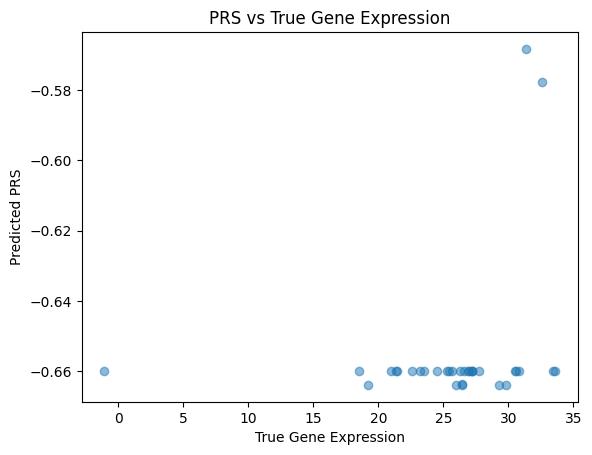

In [49]:
plt.scatter(merged["TrueValue"], merged["SCORE"], alpha=0.5)
plt.xlabel("True Gene Expression")
plt.ylabel("Predicted PRS")
plt.title("PRS vs True Gene Expression")
plt.show()
